In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [81]:
import numpy as np
import pandas as pd
# import tensorflow.compat.v2 as tf
# tf.enable_v2_behavior()
import tensorflow as tf
import tensorflow_probability as tfp
import keras
tfd = tfp.distributions

# Data Viz. 
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.ticker import FormatStrFormatter
# import seaborn as sns
# sns.set_style(
#     style="darkgrid", 
#     rc={"axes.facecolor": ".9", "grid.color": ".8"}
# )
# sns.set_palette(palette="deep")
# sns_c = sns.color_palette(palette="deep")
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams["figure.figsize"] = [12, 12]
plt.rcParams["figure.dpi"] = 100

# Get TensorFlow version.
print(f"TnesorFlow version: {tf.__version__}")
print(f"TnesorFlow Probability version: {tfp.__version__}")

from keras_tqdm import TQDMNotebookCallback

TnesorFlow version: 2.3.0
TnesorFlow Probability version: 0.11.1


In [82]:
class cfd:
    def __init__(self,dx):
        self.x,self.y = np.meshgrid(np.arange(-1,1,dx),np.arange(-1,1,dx))
        self.points = []
    
    def run(self,xi,yi):
        ret = np.exp(.2*(-(self.x-xi)**2-(self.y-yi)**2))
#         self.points.append([xi,yi])
        return ret
    
#     def initialize(self):
#         inputs = []
#         outputs = []
#         for xy in [[-1,-1],[-1,1],[1,-1],[1,1],[0,0]]:
#             xx,yy = self.run(xy[0],xy[1])
#             inputs.append(xx)
#             outputs.append(yy)
#             self.points.append(xy)
#         return np.array(inputs),np.array(outputs)

In [83]:
class ann:
    def __init__(self):
        
        nodesIn = 2
        nodesOut = 10
        nso = nodesOut**2
        trainSamples = 10
        inferSamples = 101

        modelVar = keras.Sequential([
            tf.keras.layers.InputLayer(nodesIn),
            tf.keras.layers.Dense(10,activation='sigmoid'),
            tf.keras.layers.Dense(nso,'sigmoid'),
            tf.keras.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(nso)),
            tfp.layers.MultivariateNormalTriL(nso),
        ])

        modelSampleTrain = tf.keras.Sequential([
            tf.keras.layers.Lambda(lambda x: tf.math.reduce_mean(tf.transpose(x.sample(trainSamples),perm=[1,0,2]),axis=1)),
            tf.keras.layers.Reshape([nodesOut,nodesOut])
        ])

        modelSampleInfer = tf.keras.Sequential([
            tf.keras.layers.Lambda(lambda x: tf.math.reduce_mean(tf.transpose(x.sample(inferSamples),perm=[1,0,2]),axis=1)),
            tf.keras.layers.Reshape([nodesOut,nodesOut])
        ])

        modelSampleInferStd = tf.keras.Sequential([
            tf.keras.layers.Lambda(lambda x: tf.math.reduce_mean(tf.math.reduce_std(x.sample(inferSamples),axis=0),axis=1)),
        ])

        self.modelTrain = tf.keras.Model(inputs=modelVar.inputs,outputs=modelSampleTrain(modelVar.outputs[0]))
        self.modelInfer = tf.keras.Model(inputs=modelVar.inputs,outputs=modelSampleInfer(modelVar.outputs[0]))
        self.modelInferStd = tf.keras.Model(inputs=modelVar.inputs,outputs=modelSampleInferStd(modelVar.outputs[0]))

        self.modelTrain.compile(optimizer='Adam',loss='MSE',metrics=['accuracy'])
    
    def train(self,x,y,epochs,verbose=0):
        cb = TQDMNotebookCallback()
        setattr(cb,'on_train_batch_begin',lambda x,y:None)
        setattr(cb,'on_train_batch_end',lambda x,y:None)
        self.modelTrain.fit(x=x,y=y,epochs=epochs,verbose=verbose,callbacks=[cb])
    
    def infer(self,x):
        ret = self.modelInfer.predict(x=x)
        return ret
    
    def var(self,x):
        ret = self.modelInferStd.predict(x=x)
        return ret

In [84]:
class activelearning:
    def __init__(self, cfdclass, annclass):
        dx = 0.2
        self.iters = 20
        self.annverbose = 1
        
        self.cfdclass = cfdclass(dx)
        self.annclass = annclass()
        
        self.x = []
        self.y = []
        
        dp = 0.01
        self.params = np.meshgrid(np.arange(-1,1,dp),np.arange(-1,1,dp))
        self.params = np.vstack([np.reshape(p,[-1]) for p in self.params]).T
        self.randomParams(1000)
    
    def randomParams(self,n):
        self.params = np.random.rand(n,2)*2-1
    
    def initialize(self):
        
        self.x = np.array([[-1,-1],[-1,1],[1,-1],[1,1],[0,0]])
        self.y = []
        for xy in self.x:
            yy = self.cfdclass.run(xy[0],xy[1])
            self.y.append(yy)
        
        self.y = np.stack(self.y,0)
        self.annclass.train(self.x,self.y,self.iters,verbose=self.annverbose)
        self.annclass.var(self.params)

    def selectMaxTriangles(self,zz,n):
        triang = tri.Triangulation(self.params[:,0],self.params[:,1])
        tris = triang.triangles
        zt = np.mean(zz[tris],axis=1)
        
        iis = np.argsort(zt)[-n:] # get the triangles with highest variance
        mtris = tris[iis,:] # each row has the indices of a triangle
        mx = np.mean(self.params[:,0][mtris],axis=1)
        my = np.mean(self.params[:,1][mtris],axis=1)
        
        xnext = np.vstack([mx,my]).T
        
        return xnext
    
    def selectMaxPoints(self,zz,n):
        iis = np.argsort(zz)[-n:]
        xnext = self.params[iis,:]
        
        return xnext
        
        
    def findnextpoints(self,n):
        self.randomParams(1000)
        self.annclass.train(self.x,self.y,self.annepochs,verbose=self.annverbose)
        zz = self.annclass.var(self.params)

        xnext = self.selectMaxTriangles(zz,n)
        print('*'*88)
        print(xnext.shape)
#         xnext = self.selectMaxPoints(zz,n)


        y = []
        for i in range(n):
            ynext = self.cfdclass.run(xnext[i,0],xnext[i,1])
            y.append(ynext)

        y = np.stack(y,0)
#         print(y.shape,self.y.shape)
        self.y = np.concatenate([self.y,y],axis=0)
        
        self.x = np.concatenate([self.x,xnext],axis=0)
    
    def iterate(self,niters,nepochs):
        self.annverbose = 0
        self.annepochs = nepochs
        for i in range(niters):
            print('iteration ',i)
            self.findnextpoints(1)
        self.annverbose = 1

    def calcvar(self):
        self.annclass.var(self.params)
      
    def fitpoints(self):
        self.annclass.train(self.x,self.y,self.iters)

    def showresults(self):
        X,Y = np.meshgrid(np.arange(-1,1+.1,.1),np.arange(-1,1+.1,.1))
        xx = np.reshape(X,[-1])
        yy = np.reshape(Y,[-1])
        xy = np.vstack([xx,yy]).T
        
        triang = tri.Triangulation(self.params[:,0],self.params[:,1])

        zz = self.annclass.var(self.params)
        cf = plt.tricontourf(self.params[:,0],self.params[:,1],zz)
        plt.scatter(self.x[:,0],self.x[:,1])
        plt.triplot(triang, lw=0.5, color='white')
        plt.colorbar(cf)
        plt.show()

In [85]:
al = activelearning(cfd,ann)

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


In [86]:
al.initialize()

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
1/1 [==============================] - ETA: 0s - loss: 0.6234 - accuracy: 0.1000

KeyError: 'metrics'

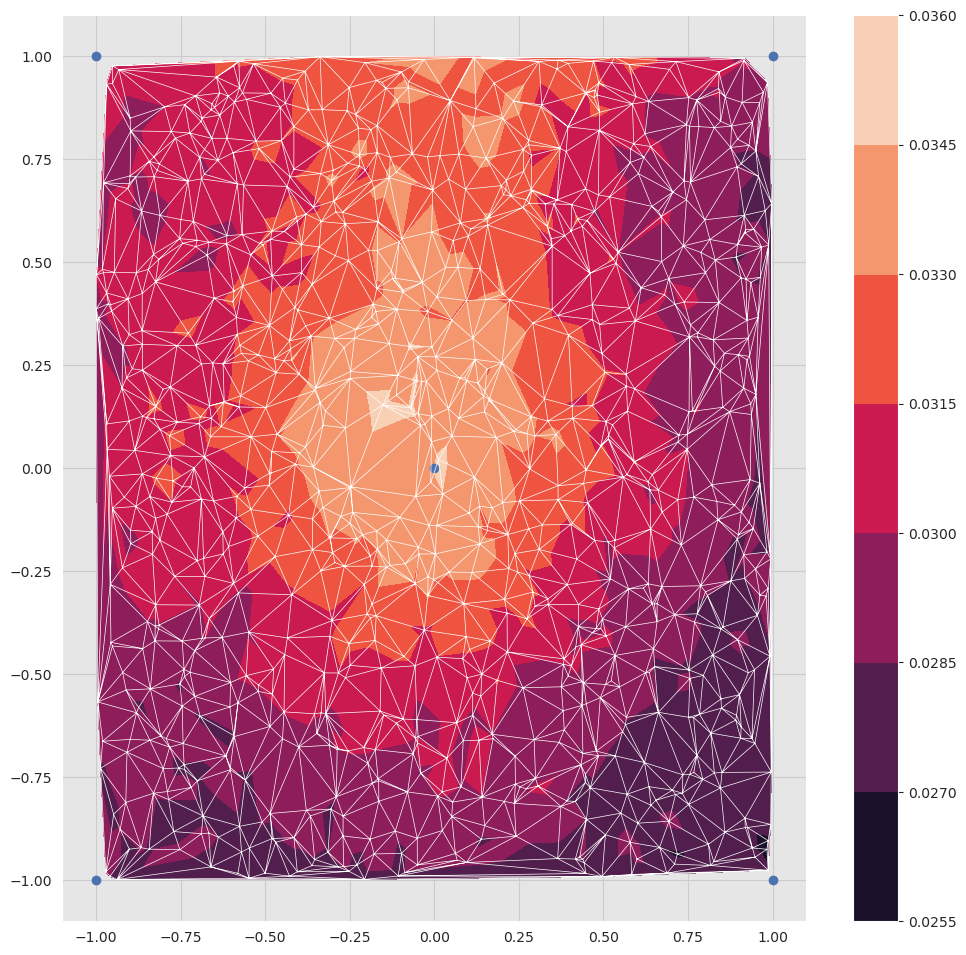

In [62]:
al.showresults()

In [63]:
al.iterate(5,200)

iteration  0
****************************************************************************************
(1, 2)
iteration  1
Consider rewriting this model with the Functional API.
****************************************************************************************
(1, 2)
iteration  2
****************************************************************************************
(1, 2)
iteration  3
****************************************************************************************
(1, 2)
iteration  4
****************************************************************************************
(1, 2)


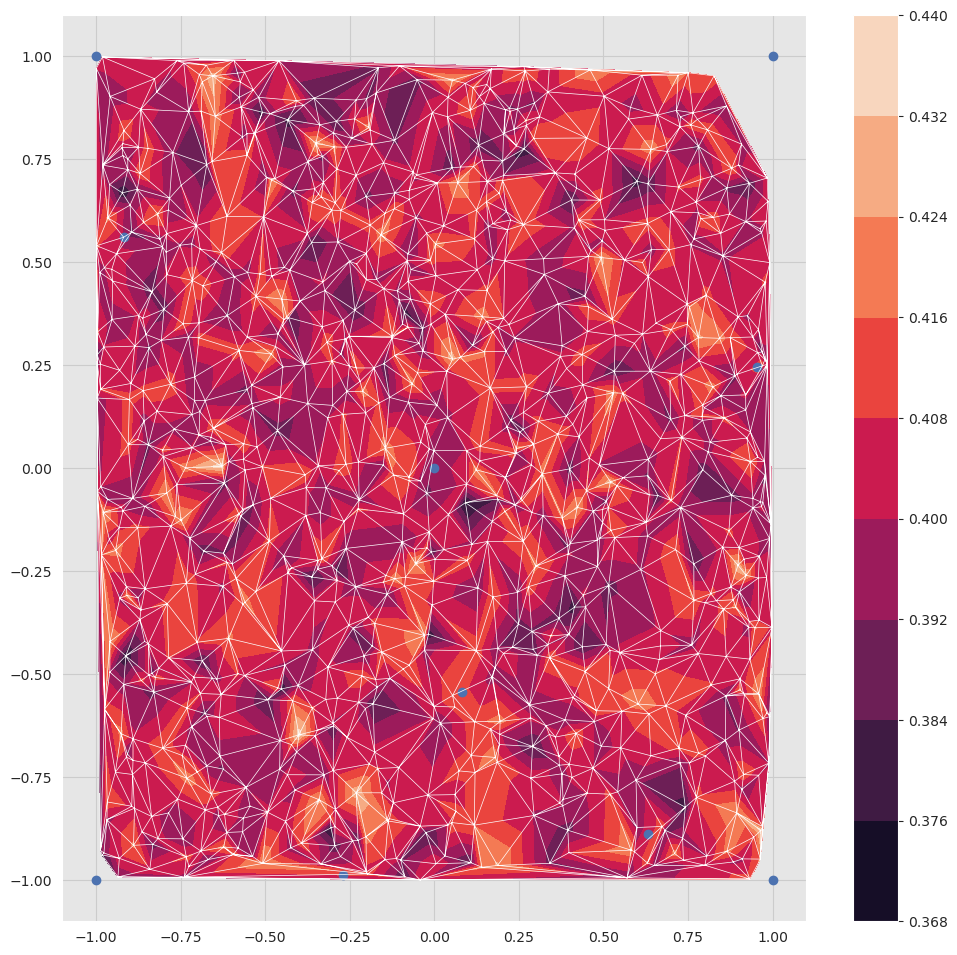

In [23]:
al.showresults()

In [12]:
al.iterate(5,20000) 

iteration  0
iteration  1
iteration  2
iteration  3
iteration  4


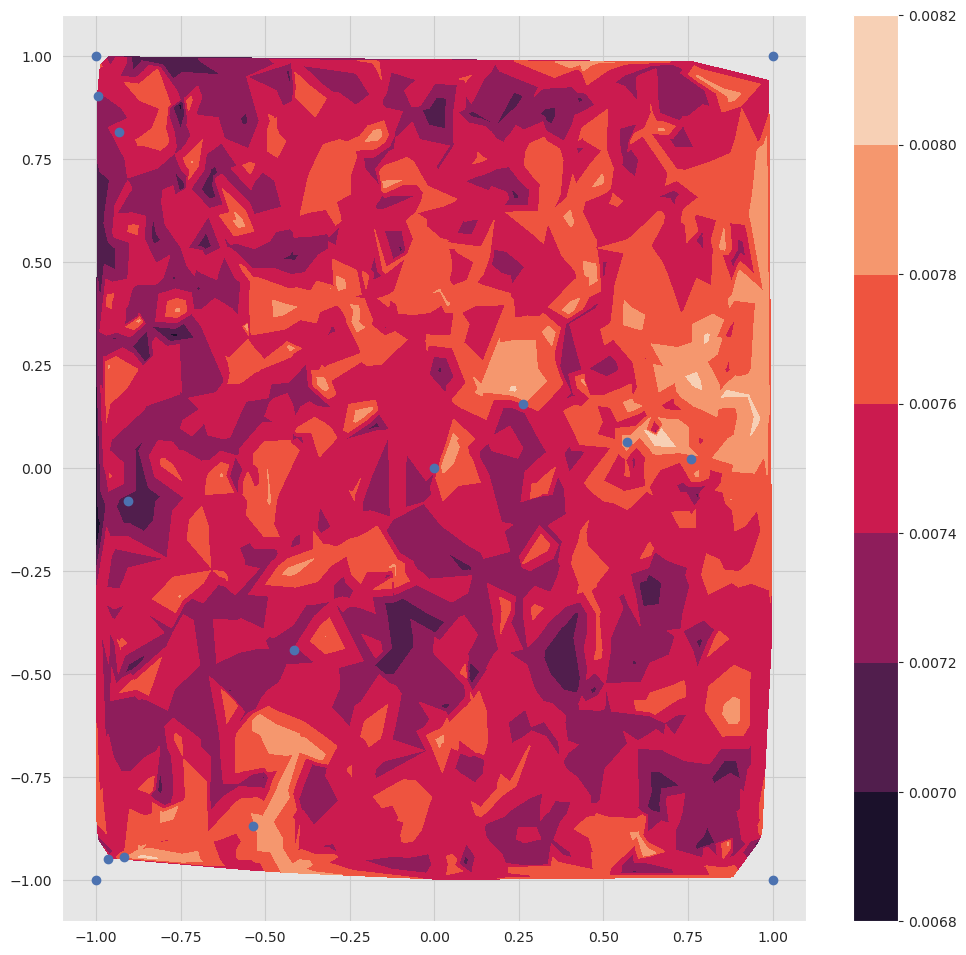

In [13]:
al.showresults()

In [14]:
al.iterate(5,20000)

iteration  0
iteration  1
iteration  2
iteration  3
iteration  4


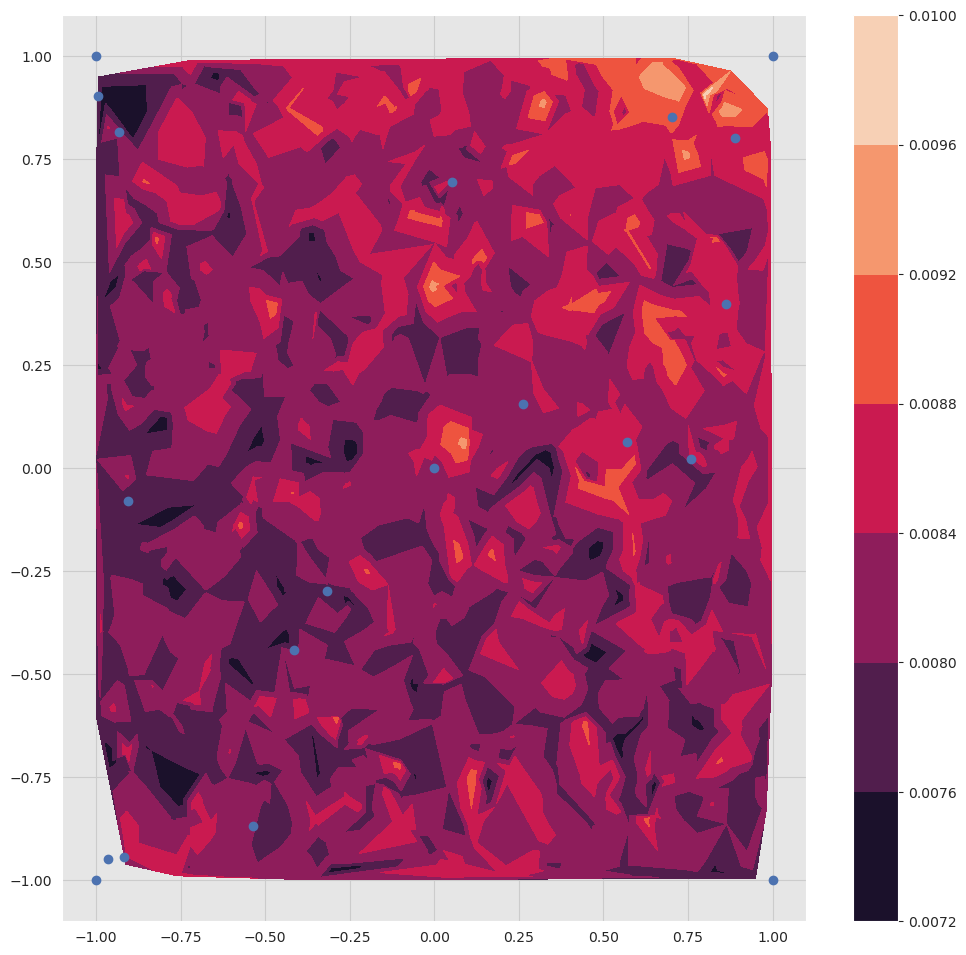

In [15]:
al.showresults()

In [16]:
al.iterate(5,20000)

iteration  0
iteration  1
iteration  2
iteration  3
iteration  4


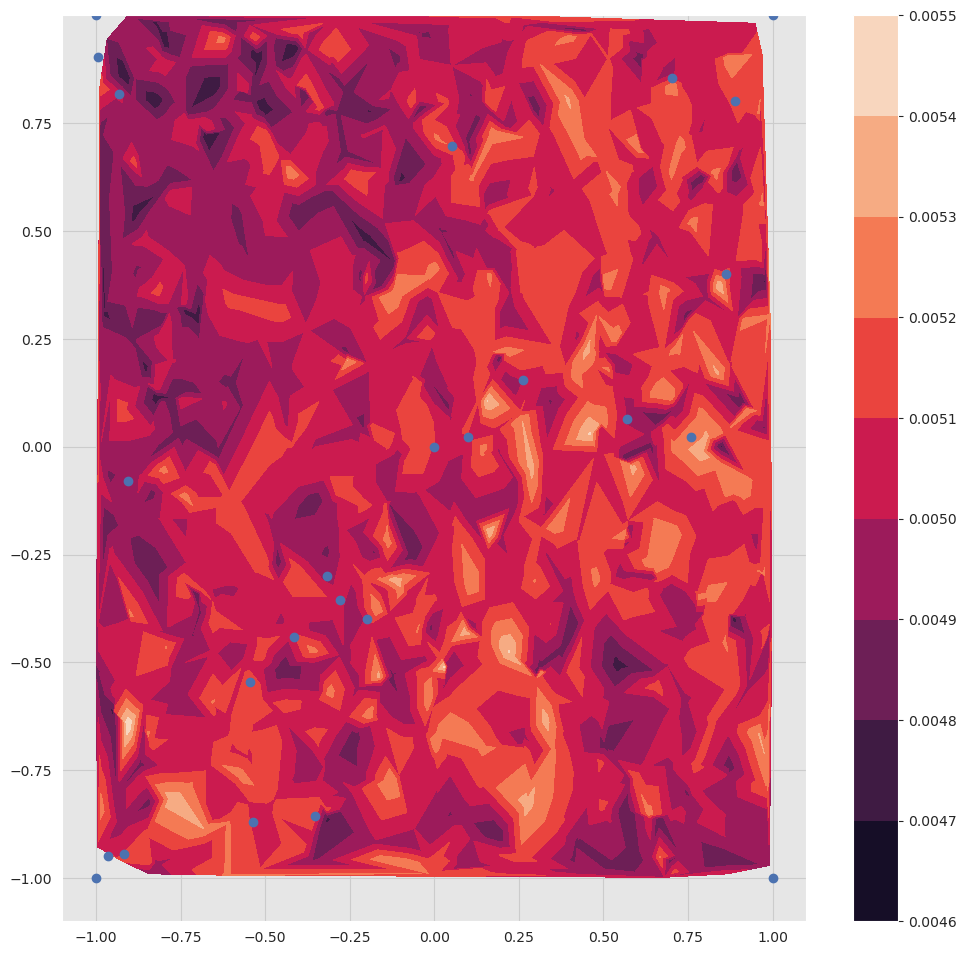

In [17]:
al.showresults()

In [18]:
al.iterate(5,20000)

iteration  0
iteration  1
iteration  2
iteration  3
iteration  4


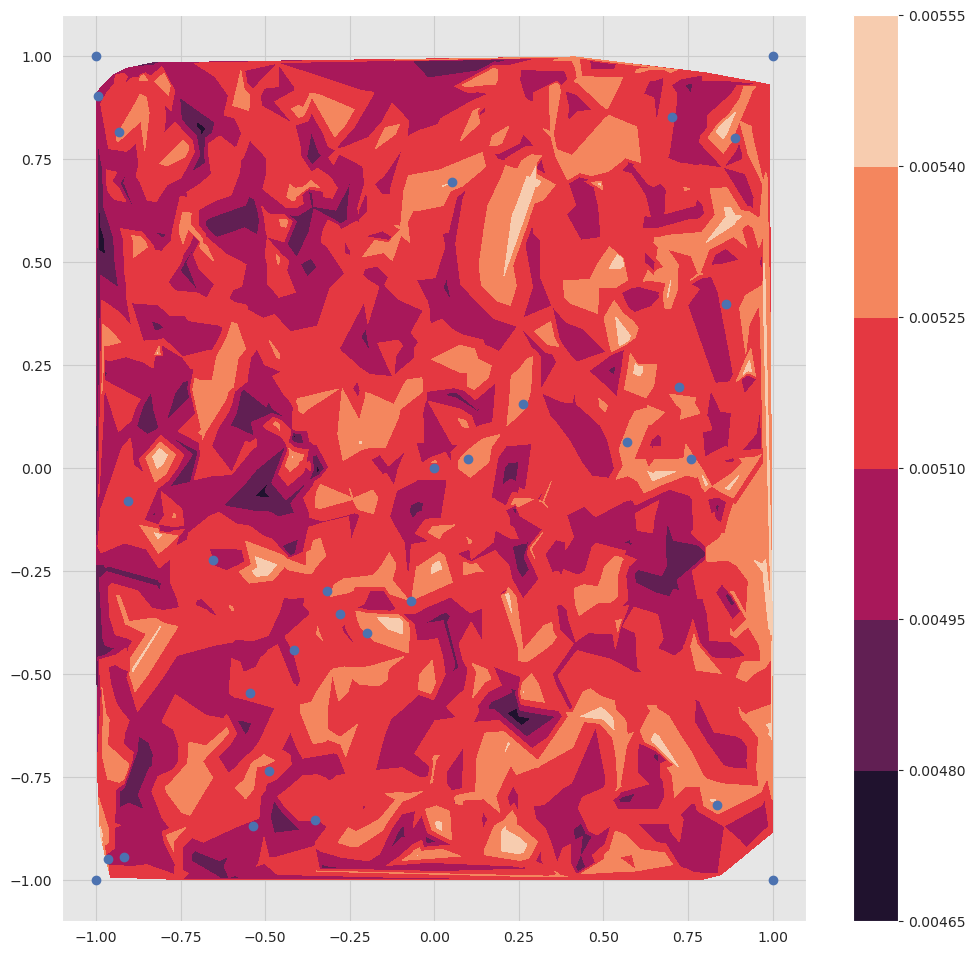

In [19]:
al.showresults()

In [25]:
triang = tri.Triangulation(np.random.rand(10),np.random.rand(10))

In [30]:
triang.triangles

array([[9, 1, 6],
       [1, 9, 3],
       [6, 1, 8],
       [1, 2, 8],
       [8, 2, 0],
       [4, 3, 7],
       [7, 3, 9],
       [5, 2, 1],
       [1, 3, 5],
       [0, 2, 5],
       [4, 0, 5],
       [5, 3, 4]], dtype=int32)

In [31]:
x=np.random.rand(20)
y=np.random.rand(20)
triang = tri.Triangulation(x,y)
tris = triang.triangles

In [34]:
z=x**2+y**2

In [38]:
np.mean(z[tris],axis=1)

array([0.40867143, 0.9798406 , 1.15055364, 1.09955562, 0.81052642,
       0.52676657, 0.56490289, 0.86659651, 0.70030824, 1.06051088,
       0.78610474, 1.07513394, 1.13231661, 0.67761193, 0.8948354 ,
       1.04086938, 1.05435011, 0.98962424, 0.26593411, 0.30332892,
       0.61349923, 0.46116846, 0.46190998, 0.67475666, 0.84178645,
       0.7797875 , 0.36924444, 0.35306053, 0.40738077, 0.39119685])

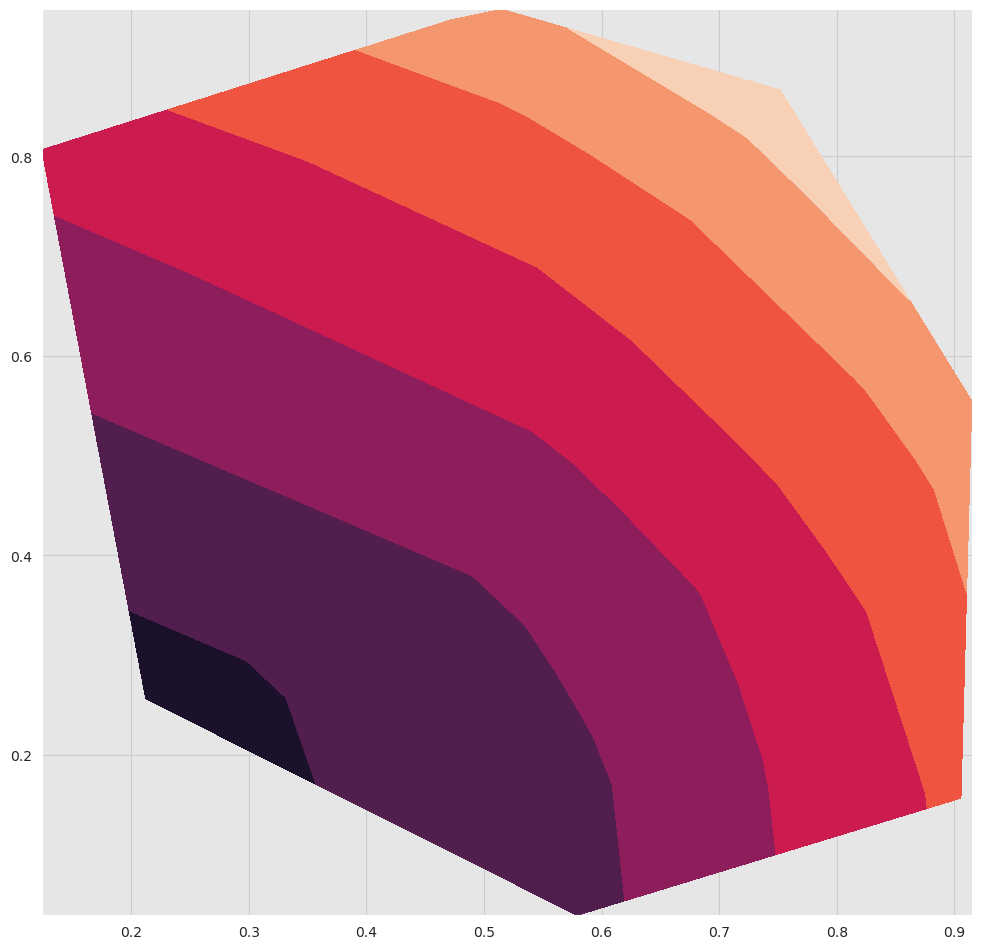

In [35]:
plt.tricontourf(x,y,z)
plt.show()